Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

In [1]:
model_name = 'sklearn-iris-model'
model_version = '1'
endpoint_name = "sklearn-iris-online-endpoint"
deployment_name = "blue"

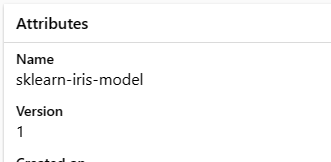

In [2]:
from azure.ai.ml import MLClient, Input
from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment, Model
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential
import datetime
import pandas as pd

In [3]:
# load enter details of your AML workspace from .env file
from dotenv import load_dotenv
import os

load_dotenv()

subscription_id = os.environ.get("subscription_id")
resource_group = os.environ.get("resource_group")
workspace = os.environ.get("workspace")

# get a handle to the workspace
ml_client = MLClient(
    DefaultAzureCredential(), 
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    workspace_name=workspace
)

# Deploy an MLflow model to an online endpoint

First. we need to configure the endpoint where the model will be deployed. The following example configures the name and authentication mode of the endpoint:

In [4]:
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,
    description="An online endpoint to generate predictions for the diabetes dataset",
    auth_mode="key",
    tags={"stage": "dev"},
)

# Let's create the endpoint:
ml_client.begin_create_or_update(endpoint)


Now, it is time to configure the deployment. A deployment is a set of resources required for hosting the model that does the actual inferencing.

In [5]:
# get model
model = ml_client.models.get(model_name, version=model_version)


blue_deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=endpoint_name,
    model=model,
    instance_type="Standard_F4s_v2",
    instance_count=1
)

# Let's create the deployment

ml_client.online_deployments.begin_create_or_update(blue_deployment)

Check: endpoint sklearn-iris-online-endpoint exists
data_collector is not a known attribute of class <class 'azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.ManagedOnlineDeployment'> and will be ignored


In [6]:
# Assign all the traffic to the deployment: So far, the endpoint has one deployment, but none of its traffic is assigned to it. Let's assign it.

endpoint.traffic = { blue_deployment: 100 }

## Deployment could take few minutes to complete. Please wait...

# Test deployment

In [7]:
# create json data to send to the service
import json

data = {
    "input_data": {
        "columns": [
            "sepal length (cm)",
            "sepal width (cm)",
            "petal length (cm)",
            "petal width (cm)"
        ],
        "index": [0, 1, 2, 3],
        "data": [[5.1, 3.5, 1.4, 0.2],
                 [4.9, 3.0, 1.4, 0.2],
                 [6.2, 2.9, 4.3, 1.3],
                 [4.9, 3.1, 1.5, 0.1]
                 ]
    }
}

# write the json data to a file
with open("./data/data.json", "w") as _f:
    _f.write(json.dumps(data))


.

In [8]:
ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    request_file="./data/data.json",
)

ServiceResponseError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

......................................................................................................